# This Looks Like That There

Visualize the prototypes

In [1]:
import os
import sys
import imp 

import numpy as np
from tqdm import tqdm
from tqdm import trange
from icecream import ic          # pip install icecream
import scipy.io as sio


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import seaborn as sns
import cmasher as cmr            # pip install cmasher

import cartopy as ct
import cartopy.crs as ccrs

import tensorflow as tf

import network
import experiment_settings 
import data_functions
import push_prototypes
import plots
import common_functions

import warnings
warnings.filterwarnings( "ignore", module = "cartopy\..*" )
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

In [2]:
__author__ = "Elizabeth A. Barnes and Randal J Barnes"
__version__ = "13 December 2021"

In [3]:
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
dpiFig = 400.

## Print the detailed system info

In [4]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")

python version = 3.9.4 (default, Apr  9 2021, 09:32:38) 
[Clang 10.0.0 ]
numpy version = 1.20.1
tensorflow version = 2.5.0


## Define experiment settings and directories

In [5]:
EXP_NAME = 'mjo'#'mjo'#'quadrants'

imp.reload(experiment_settings)
settings = experiment_settings.get_settings(EXP_NAME)

imp.reload(common_functions)
model_dir, model_diagnostics_dir, vizualization_dir = common_functions.get_exp_directories(EXP_NAME)

## Define the network parameters

In [6]:
RANDOM_SEED          = settings['random_seed']
BATCH_SIZE_PREDICT   = settings['batch_size_predict']
BATCH_SIZE           = settings['batch_size']
NLAYERS              = settings['nlayers']
NFILTERS             = settings['nfilters']   
DOUBLE_CONV          = settings['double_conv']   
assert(len(NFILTERS)==NLAYERS)

NCLASSES             = settings['nclasses']
PROTOTYPES_PER_CLASS = settings['prototypes_per_class']
NPROTOTYPES          = np.sum(PROTOTYPES_PER_CLASS)

NEPOCHS              = settings['nepochs']
LR_INIT              = settings['lr']
LR_EPOCH_BOUND       = 10000
PATIENCE             = 100

STAGE                = settings['analyze_stage']

## Initialize

In [7]:
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Get and process the data

In [8]:
imp.reload(data_functions)
DATA_NAME = settings['data_name']
DATA_DIR = settings['data_dir']

if(EXP_NAME[:3]=='mjo'):

    labels, data, lat, lon, time = data_functions.load_mjo_data(DATA_DIR)
    X_train, y_train, time_train, X_val, y_val, time_val, X_test, y_test, time_test = data_functions.get_and_process_mjo_data(labels,
                                                                                         data,
                                                                                         time,
                                                                                         rng, 
                                                                                         colored=settings['colored'],
                                                                                         standardize=settings['standardize'],
                                                                                         shuffle=settings['shuffle'],
                                                                                        )        
elif(EXP_NAME[:9]=='quadrants'):
    filename = DATA_DIR + DATA_NAME + '.mat'
    X_train, y_train, X_val, y_val, X_test, y_test, lat, lon = data_functions.get_and_process_data(filename, 
                                                                                        rng, 
                                                                                        colored=settings['colored'],
                                                                                        standardize=settings['standardize'],
                                                                                        shuffle=settings['shuffle'],
                                                                                        )      
    

[0 1 2 3 4 5 6 7 8]


ic| years_train: array([1901, 1900, 1979, 1908, 2004, 1920, 1932, 1951, 1985, 1924, 1956,
                        1952, 2000, 1996, 1938, 1991, 1973, 1921, 1960, 1977, 1982, 1969,
                        1994, 1988, 1998, 1978, 1970, 2003, 2002, 1963, 1997, 1931, 1910,
                        1993, 1904, 1942, 1981, 1967, 1966, 1983, 1989, 2006, 1974, 1984,
                        1980, 1943, 1934, 1971, 1929, 1930, 1919, 1986, 1914, 1959, 1926,
                        1999, 1905, 1975, 1948, 1954, 1925, 1940, 1922, 1936, 1968, 1947,
                        1990, 1909, 1939, 1972, 2009, 1944, 1957, 1958, 1928, 1955, 1933,
                        1950, 1913, 2005, 1915, 1911, 1987, 1964, 1995, 2001, 1927, 1962,
                        1906])
ic| years_val: array([1902, 1903, 1907, 1912, 1916, 1917, 1918, 1923, 1935, 1937, 1941,
                      1945, 1946, 1949, 1953, 1961, 1965, 1976, 1992, 2007, 2008, 2010])
ic| years_test: 2010


raw_data        = (40422, 17, 105, 3)
training data   = (32387, 17, 105, 3), (32387,)
validation data = (8035, 17, 105, 3), (8035,)
test data       = (365, 17, 105, 3), (365,)
X_mean          = 0.00029500475989341156
X_std           = 1.0281252570023809


In [9]:
proto_class_mask = network.createClassIdentity(PROTOTYPES_PER_CLASS)

prototypes_of_correct_class_train = np.zeros((len(y_train),NPROTOTYPES))
for i in range(0,prototypes_of_correct_class_train.shape[0]):
    prototypes_of_correct_class_train[i,:] = proto_class_mask[:,int(y_train[i])]
    
prototypes_of_correct_class_val   = np.zeros((len(y_val),NPROTOTYPES))    
for i in range(0,prototypes_of_correct_class_val.shape[0]):
    prototypes_of_correct_class_val[i,:] = proto_class_mask[:,int(y_val[i])]

prototypes_of_correct_class_test   = np.zeros((len(y_test),NPROTOTYPES))    
for i in range(0,prototypes_of_correct_class_test.shape[0]):
    prototypes_of_correct_class_test[i,:] = proto_class_mask[:,int(y_test[i])]
    

## Get the model and make predictions

In [10]:
model_filename = model_dir + 'model_' + EXP_NAME + '_stage' + str(STAGE)
model = common_functions.load_model(model_filename)

model_final_conv_layer = network.get_model_final_conv_layer(model)
model_prototype_layer  = network.get_model_prototype_layer(model)

local_mask = np.exp(model.layers[-3].get_weights()[1])

loading model from ./saved_models/mjo/model_mjo_stage9


# Compute the prototypes

In [11]:
imp.reload(network)

model_cnn_only = network.build_model(
    nlayers=NLAYERS,
    nfilters=NFILTERS,
    input_shape= X_train.shape[1:],
    output_shape=NCLASSES,
    prototypes_per_class=PROTOTYPES_PER_CLASS,
    network_seed=RANDOM_SEED,
    cnn_only=True,
    double_conv=DOUBLE_CONV,    
)
# model_cnn_only.summary()

model_cnn_only = network.get_model_cnn_only_conv_layer(model_cnn_only)
# model_cnn_only.summary()

3
[16, 16, 16]
(17, 105, 3)
9
[10, 10, 10, 10, 10, 10, 10, 10, 10]
30
False
0.05
-0.005
0.01
-0.5
True
8
32
0.0
0.0
0.0
0.0
False


In [12]:
print('running receptive field calculation...')
receptive_field = network.ReceptiveField(model_cnn_only)
print('receptive field calculation complete.')

running receptive field calculation...
receptive field calculation complete.


In [13]:
input_train      = [[X_train,prototypes_of_correct_class_train]]

# get the prototypes
imp.reload(push_prototypes)
model, push_info = push_prototypes.push(model, 
                                        input_train[0], 
                                        prototypes_of_correct_class_train,
                                        perform_push=False,
                                        batch_size=BATCH_SIZE_PREDICT,
                                        verbose=0,
                                       )
prototype_sample  = push_info[0]
prototype_indices = push_info[-1]
similarity_scores = push_info[-2]
# prototype_date = time_train.dt.strftime("%b %d %Y").values[prototype_sample]    

Running Prototype Push
11/11 [==============================] - 1s 104ms/step


In [14]:
model.summary()

Model: "full_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 17, 105, 3)] 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 17, 105, 16)  448         inputs[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 17, 105, 16)  0           conv_0[0][0]                     
__________________________________________________________________________________________________
maxpooling_0 (AveragePooling2D) (None, 8, 52, 16)    0           dropout[0][0]                    
_________________________________________________________________________________________

## Validation samples

In [15]:
input_val  = [[X_val,prototypes_of_correct_class_val]]

print('running model.predict()...')
y_predict_val = model.predict(input_val, batch_size=BATCH_SIZE_PREDICT, verbose=1)
print('model.predict() complete.')

model.evaluate(input_val,y_val,batch_size=BATCH_SIZE_PREDICT, verbose=1)

running model.predict()...
8/8 [==============================] - 1s 148ms/step
model.predict() complete.
8/8 [==============================] - 2s 161ms/step - loss: 0.8490 - sparse_categorical_accuracy: 0.7277 - cluster_cost: 0.0033 - separation_cost: 6.7313e-04 - l1_weights_cost: 0.0902


[0.8490433692932129,
 0.7276913523674011,
 0.003259203862398863,
 0.0006731260218657553,
 0.09022477269172668]

In [16]:
print('Accuracies by class: ')

for c in np.arange(0,NCLASSES):
    i = np.where(y_val==c)[0]
    j = np.where(y_val[i]==np.argmax(y_predict_val[i],axis=1))[0]
    acc = np.round(len(j)/len(i),3)
    
    print('   phase ' + str(c) + ' = ' + str(acc))
    

Accuracies by class: 
   phase 0 = 0.701
   phase 1 = 0.706
   phase 2 = 0.767
   phase 3 = 0.798
   phase 4 = 0.714
   phase 5 = 0.663
   phase 6 = 0.771
   phase 7 = 0.717
   phase 8 = 0.694


In [17]:
#-------------
y_predict  = y_predict_val
y_true     = y_val
# time       = time_val
input_data = input_val
#-------------

imp.reload(push_prototypes)

# get similarity maps
inputs_to_prototype_layer = model_final_conv_layer.predict(input_data)
prototypes = model.layers[-3].get_weights()[0]
similarity_scores = push_prototypes.get_similarity_maps(inputs_to_prototype_layer, 
                                                        prototypes, 
                                                        local_mask,
                                                        batch_size=BATCH_SIZE_PREDICT,
                                                       )
# get winning similarity scores across maps for each prototype and sample
max_similarity_score = model_prototype_layer.predict(input_data)

# get final weights
w = np.round(model.layers[-2].get_weights()[0],3)

# Plot Prototypes and Samples

In [18]:
### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([]) 
            
# adjust_spines(ax, ['left', 'bottom'])
# ax.spines['top'].set_color('none')
# ax.spines['right'].set_color('none')
# ax.spines['left'].set_color('dimgrey')
# ax.spines['bottom'].set_color('dimgrey')
# ax.spines['left'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)            

In [19]:
raise ValueError('here')

ValueError: here

In [ ]:
# y_predict_class = np.argmax(y_predict,axis=1)
# igrab_samples = np.where(y_predict_class==0)[0]

# y_predict_class = np.argmax(y_predict,axis=1)
# igrab_samples = np.where(y_predict_class==2)[0]

## QUADRANTS EXPERIMENTS

In [ ]:
if EXP_NAME[:9] == 'quadrants':
    imp.reload(plots)
#     SAMPLES = np.random.choice(np.arange(0,len(y_predict[:,0])), size=3)
#     SAMPLES = (23,209,472)
    SAMPLES = (230,78,153)
#     SAMPLES = np.random.choice(igrab_samples,size=3)
    colors = ('tab:purple','tab:orange','tab:green')
    FS = 6
    letters = ('(a)','(b)','(c)')
    #------------------------------
    fig = plt.figure(figsize=(4,6.5), constrained_layout=True)
    spec = gridspec.GridSpec(ncols=4, nrows=6, figure=fig)

    for isample, sample in enumerate(SAMPLES):

        y_predict_class = int(np.argmax(y_predict[sample]))
        points = max_similarity_score[sample,:]*w[:,y_predict_class]

        if(np.argmax(y_predict[sample]) != y_true[sample]):
            continue

        #-------------------------------    
        base_row = (isample)*2

        # PLOT THE SAMPLE
        ax_samp = fig.add_subplot(spec[base_row:base_row+2,0:2],aspect='equal')
        img = np.squeeze(input_data[0][0][sample,:,:,:])
        p = plots.plot_sample(ax_samp, img)
        plt.title(letters[isample] + ' Sample ' + str(sample) + ', class = ' + str(y_predict_class), fontsize=FS*1.8)
        #----------------------   
        for sorted_index in (1,2):
            
            if(sorted_index==1):
                subletters = ('(i)','(ii)')
            elif(sorted_index==2):
                subletters = ('(iii)','(iv)')                
                
            
            prototype_points = np.sort(points)[-(sorted_index)]
#             print(np.sort(points)[-4:])
            prototype_index = np.where(points == prototype_points)[0][0]
            prototype_class = np.argmax(proto_class_mask[prototype_index])
            if(y_predict_class != prototype_class):
                print_warning = '\n- prototype not associated with predicted class -'
            else:
                print_warning = ''

            #-------------------------------        
            # PLOT POINTS AS TEXT IN MAIN SAMPLE IMAGE
            ax_samp.text(0.02,0.98*(1.-(sorted_index-1)*.05),
                     str(np.round(prototype_points,1)) + ' points', 
                     color=colors[sorted_index-1],
                     horizontalalignment='left',
                     verticalalignment='top',
                     transform=ax_samp.transAxes,
                     fontsize=FS)
                            
            #-------------------------------        
            # PLOT THE PROTOTYPE SQUARE IN SAMPLE
            similarity_map  = similarity_scores[sample,:,:,prototype_index]
            j,k             = np.unravel_index(np.argmax(similarity_map), shape=similarity_map.shape)
            rf              = receptive_field.computeMask(j,k)
            q = plots.display_rfpatch(ax_samp, rf, clr=colors[sorted_index-1])

            #-------------------------------        
            # PLOT THE PROTOTYPES
            ax = fig.add_subplot(spec[base_row+sorted_index-1,2],aspect='equal')
            rf = receptive_field.computeMask(prototype_indices[prototype_index,0], prototype_indices[prototype_index,1])
            img = np.squeeze(input_train[0][0][prototype_sample[prototype_index],:,:,:])
            p = plots.plot_sample(ax, img,)
            q = plots.display_rfpatch(ax, rf, clr=colors[sorted_index-1])
            plt.setp(ax.spines.values(), color=colors[sorted_index-1],linewidth=2)        
            plt.title(subletters[0] + ' Prototype ' + str(prototype_index) + '\nTraining Sample ' + str(np.round(prototype_sample[prototype_index],1)), fontsize=FS)
#             plt.title('Prototype ' + str(prototype_index) + '\n' + str(np.round(prototype_points,1)) + ' points', fontsize=FS)


            #-------------------------------        
            # PLOT THE MASKS
            ax = fig.add_subplot(spec[base_row+sorted_index-1,3],aspect='equal')
            rf = receptive_field.computeMask(prototype_indices[prototype_index,0], prototype_indices[prototype_index,1])
            rf[rf==0] = np.nan
            img = local_mask[:,:,prototype_index] # flip map images because of latitude flipping the image
            p = plots.plot_mask(ax,img)
#             p.set_clim(.5,np.max(img)*.5)
            p.set_clim(0.,np.max(img))
            plt.title(subletters[1] + ' Prototype ' + str(prototype_index) + '\nLocation Scaling', fontsize=FS)
            plt.setp(ax.spines.values(), color=colors[sorted_index-1],linewidth=2)        


    # plt.close()    
#     plt.tight_layout()
    plt.savefig((vizualization_dir + EXP_NAME + '_samples_prototypes.png'), bbox_inches='tight', dpi=dpiFig)
    plt.show()



## MJO EXPERIMENT

In [20]:
if EXP_NAME[:3] == 'mjo':
    prototype_date = time_train.dt.strftime("%b %d %Y").values[prototype_sample]
    sample_date = time_val.dt.strftime("%b %d %Y").values

In [ ]:
if EXP_NAME[:3] == 'mjo':
    FS = 16   
    fig, axs = plt.subplots(1,
                        1, 
                        figsize=(21/2.5,12/2.5)
                       )

    for phase in np.arange(0,9):
        i = np.where(y_true==phase)[0]
        j = np.where(y_true[i]==np.argmax(y_predict[i],axis=1))[0]
        acc = np.round(len(j)/len(i),3)
    #     print('   phase ' + str(phase) + ' = ' + str(acc))

        plt.bar(phase, int(acc*100))
        plt.xticks(np.arange(0,9,1),('0', '1', '2','3', '4', '5', '6', '7', '8'), fontsize=FS)
        plt.ylabel('accuracy (\%)', fontsize=FS)
        plt.xlabel('MJO phase', fontsize=FS)
        plt.title('Testing accuracy for MJO phase classification', fontsize=FS)
        plt.xlim(-.5,8.5)
        plt.ylim(0,100)
        plt.yticks(np.arange(0,110,10),np.around(np.arange(0,110,10),2), fontsize=FS)

        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        [t.set_color(i) for (i,t) in
         zip(colors,axs.xaxis.get_ticklabels())]    

    plt.savefig((vizualization_dir + EXP_NAME + '_phase_accuracy.png'), bbox_inches='tight', dpi=dpiFig)
    plt.show()        

In [ ]:
if EXP_NAME[:3] == 'mjo':
    
    sample = 2210
    
    for var_index in (0,1,2):
        if(var_index==0):
            var_name = 'olr'
        elif(var_index==1):
            var_name = 'u200'
        elif(var_index==2):
            var_name = 'u850'          
        
        mapProj = ct.crs.EqualEarth(central_longitude = np.mean(lon.values))
        fig = plt.figure(figsize=(10,2), constrained_layout=True)
        ax = fig.add_subplot(1,1,1,projection=mapProj)

        img = np.squeeze(input_data[0][0][sample,:,:,var_index])
        p = plots.plot_sample(ax, img, globe=True, lat=lat, lon=lon, mapProj=mapProj)

        ax.set_extent([np.min(lon), 
                      (np.max(lon) - np.min(lon))/2, 
                       np.min(lat), 
                       np.max(lat)], 
                      crs=ccrs.PlateCarree())        
        
        plt.savefig((vizualization_dir + EXP_NAME + '_example_input_' + str(var_name) + '.png'), bbox_inches='tight', dpi=dpiFig)
#         plt.show()
        plt.close()

    for var_index in (0,1,2):
        if(var_index==0):
            var_name = 'olr'
        elif(var_index==1):
            var_name = 'u200'
        elif(var_index==2):
            var_name = 'u850'          
        
        mapProj = ct.crs.EqualEarth(central_longitude = np.mean(lon.values))
        fig = plt.figure(figsize=(10,2), constrained_layout=True)
        ax = fig.add_subplot(1,1,1,projection=mapProj)

        img = np.squeeze(input_data[0][0][sample,:,:,var_index])
        p = plots.plot_sample(ax, img, globe=True, lat=lat, lon=lon, mapProj=mapProj)     
        
        plt.savefig((vizualization_dir + EXP_NAME + '_example_input_' + str(var_name) + '_long.png'), bbox_inches='tight', dpi=dpiFig)
#         plt.show()
        plt.close()

In [ ]:
# Most winning prototypes
imp.reload(plots)
if EXP_NAME[:3] == 'mjo':
    from scipy import stats
    imp.reload(plots)
    mapProj = ct.crs.EqualEarth(central_longitude = np.mean(lon.values))
    FS = 10
    
    fig, axs = plt.subplots(9,
                        4, 
                        figsize=(21,12),
                        subplot_kw={'projection': mapProj}
                       )

    for phase in np.arange(0,9):
        for ivar, var_index in enumerate((1,2,0)):
            if(var_index==0):
                var_name = 'olr'
            elif(var_index==1):
                var_name = 'u200'
            elif(var_index==2):
                var_name = 'u850'        

            isamples = np.where((np.argmax(y_predict,axis=1)==phase) & (np.argmax(y_predict,axis=1)==y_true))[0]
            points = max_similarity_score[isamples,:]*w[:,phase]
            k = np.where(proto_class_mask[:,phase]==0)[0]
            points[:,k] = 0.
            winning_prototype = np.argmax(points,axis=1)
            most_freq_winner, count = stats.mode(winning_prototype)
            
            # for second most frequent
#             index_delete = np.where(winning_prototype==most_freq_winner)[0]
#             winning_prototype = np.delete(winning_prototype,index_delete)

            most_freq_winner, count = stats.mode(winning_prototype)
            prototype_index = int(most_freq_winner[0])
            freq = int(np.round(count[0]/len(winning_prototype)*100.))
            if(var_index==0):
                print('phase = ' + str(phase) + ': ' + str(np.round(freq)) + '%')

            #-------------------------------        
            # PLOT THE PROTOTYPES
            ax = axs[phase,ivar]
            rf = receptive_field.computeMask(prototype_indices[prototype_index,0], prototype_indices[prototype_index,1])
            img = np.squeeze(input_train[0][0][prototype_sample[prototype_index],:,:,var_index])*rf
            p = plots.plot_sample(ax,
                                  img,
                                  globe=True,
                                  lat=lat.values,
                                  lon=lon.values,
                                  mapProj=mapProj,
                                 )
            ax.set_extent([np.min(lon.values), 
                           np.max(lon.values), 
                           np.min(lat.values), 
                           np.max(lat.values)], 
                          crs=ccrs.PlateCarree())
            p.set_clim(-7,7)
            ax.set_title(var_name + ' of Prototype ' + str(prototype_index), fontsize=FS*1.25)
            ax.text(0.01, 1.0, 
                'phase ' + str(phase),
                fontfamily='monospace', 
                fontsize=FS, 
                va='bottom',
                ha='left',
                transform = ax.transAxes,
               )
            ax.text(0.99, 1.0, 
                str(prototype_date[prototype_index]),
                fontfamily='monospace', 
                fontsize=FS, 
                va='bottom',
                ha='right',
                transform = ax.transAxes,
               )            
            
        #-------------------------------        
        # PLOT THE MASKS
        ax = axs[phase,3]
        img = local_mask[:,:,prototype_index] 
        img = np.flipud(img)
        p = plots.plot_mask(ax,img)
#         p.set_clim(1.,65.1)
        p.set_clim(1.,np.max(img[:]))
        ax.set_title('Prototype ' + str(prototype_index) + ' Location Scaling', fontsize=FS)
    
#     plt.suptitle('Most Common Winning Prototype', fontsize=20)
    
    plt.savefig((vizualization_dir + EXP_NAME + '_mostFrequentWinningPrototype.png'), bbox_inches='tight', dpi=dpiFig)
#     plt.savefig((vizualization_dir + EXP_NAME + '_secondMostFrequentWinningPrototype.png'), bbox_inches='tight', dpi=dpiFig)
    plt.show()    

In [ ]:
# Prototypes by month of the year
imp.reload(plots)
if EXP_NAME[:3] == 'mjo':
    FS = 16
    
    fig, axs = plt.subplots(1,
                        1, 
                        figsize=(21/2.5,12/2.5)
                       )
    prototype_months = time_train.dt.month.values[prototype_sample[10:]]    
    plt.hist(prototype_months, 
             bins=np.arange(.5,13.5,1.),
             density=False, 
             rwidth=.8,
             color='teal',
            )
        
    plt.xticks(np.arange(1,13,1),('Jan', 'Feb', 'Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), fontsize=FS)
    plt.ylabel('\# of prototypes (out of 80)', fontsize=FS)
    plt.title('Seasonality of learned prototypes for phases 1-8', fontsize=FS)
    plt.yticks(np.arange(0,20,2),np.around(np.arange(0,20,2),2), fontsize=FS)
    
    plt.savefig((vizualization_dir + EXP_NAME + '_seasonality_learned_prototypes_activeOnly.png'), bbox_inches='tight', dpi=dpiFig)
    plt.show()    

In [ ]:
# Prototypes by month of the year
imp.reload(plots)
if EXP_NAME[:3] == 'mjo':
    FS = 16
    
    fig, axs = plt.subplots(1,
                        1, 
                        figsize=(21/2.5,12/2.5)
                       )
    prototype_months = time_train.dt.month.values[prototype_sample]    
    plt.hist(prototype_months, 
             bins=np.arange(.5,13.5,1.),
             density=False, 
             rwidth=.8,
             color='teal',
            )
        
    plt.xticks(np.arange(1,13,1),('Jan', 'Feb', 'Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), fontsize=FS)
    plt.ylabel('\# of prototypes', fontsize=FS)
    plt.title('Seasonality of learned prototypes', fontsize=FS)
    plt.yticks(np.arange(0,20,2),np.around(np.arange(0,20,2),2), fontsize=FS)
    
    plt.savefig((vizualization_dir + EXP_NAME + '_seasonality_learned_prototypes.png'), bbox_inches='tight', dpi=dpiFig)
    plt.show()    

In [ ]:
# Prototypes by month of the year
imp.reload(plots)
if EXP_NAME[:3] == 'mjo':
    FS = 16
    
    fig, axs = plt.subplots(1,
                        1, 
                        figsize=(21/2.5,12/2.5)
                       )
    prototype_months = time_train.dt.month.values[prototype_sample]
    month_points = np.zeros(12,)
    for phase in np.arange(0,9):

        isamples = np.where((np.argmax(y_predict,axis=1)==phase) & (np.argmax(y_predict,axis=1)==y_true))[0]
        points = max_similarity_score[isamples,:]*w[:,phase]
        k = np.where(proto_class_mask[:,phase]==0)[0]
        points[:,k] = 0.
        
        for month in np.arange(0,len(month_points)):
            j = np.where(prototype_months==month+1)[0]
            month_points[month] = month_points[month] + np.sum(points[:,j])

    plt.bar(np.arange(1,13), 
             month_points/np.sum(month_points),
             color='teal',
            )
        
        
    plt.xticks(np.arange(1,13,1),('Jan', 'Feb', 'Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), fontsize=FS)
    plt.ylabel('fraction of points', fontsize=FS)
    plt.title('Fraction of of total points by prototype month', fontsize=FS)
    plt.yticks(np.arange(0,.35,.05),np.around(np.arange(0,.35,.05),2), fontsize=FS)
    plt.ylim(0,.3)
    
    plt.savefig((vizualization_dir + EXP_NAME + '_seasonality_fraction_total_points_by_prototype.png'), bbox_inches='tight', dpi=dpiFig)
    plt.show()   
# plt.close()

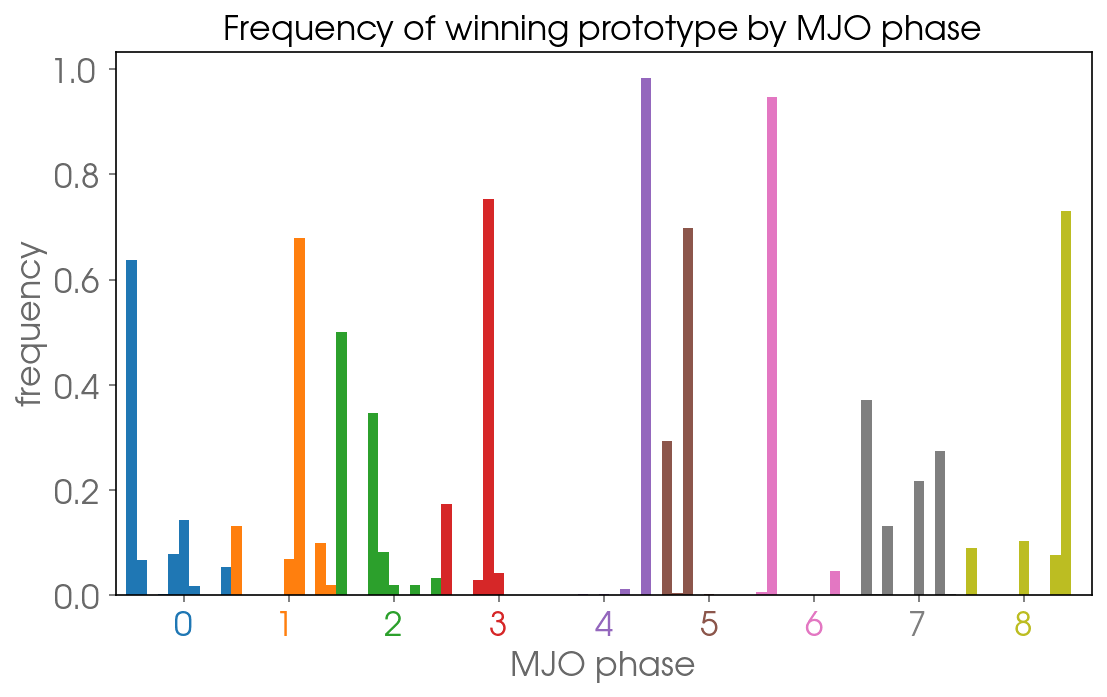

In [21]:
# Most winning prototypes
imp.reload(plots)
if EXP_NAME[:3] == 'mjo':
    from scipy import stats
    imp.reload(plots)
    FS = 16
    
    fig, axs = plt.subplots(1,
                        1, 
                        figsize=(21/2.5,12/2.5)
                       )
    for phase in np.arange(0,9):

        isamples = np.where((np.argmax(y_predict,axis=1)==phase) & (np.argmax(y_predict,axis=1)==y_true))[0]
        points = max_similarity_score[isamples,:]*w[:,phase]
        k = np.where(proto_class_mask[:,phase]==0)[0]
        points[:,k] = 0.
        winning_prototype = np.argmax(points,axis=1)
        most_freq_winner, count = stats.mode(winning_prototype)
        
        plt.hist(winning_prototype, bins=np.arange(-.5,100.5,1.),density=True)
        
    plt.xticks(np.arange(5,95,10),('0', '1', '2','3', '4', '5', '6', '7', '8'), fontsize=FS)
    plt.ylabel('frequency', fontsize=FS)
    plt.xlabel('MJO phase', fontsize=FS)
    plt.title('Frequency of winning prototype by MJO phase', fontsize=FS)
    plt.xlim(-1.5,91.5)
    plt.yticks(np.arange(0,1.2,.2),np.around(np.arange(0,1.2,.2),2), fontsize=FS)
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    [t.set_color(i) for (i,t) in
     zip(colors,axs.xaxis.get_ticklabels())]    
    
    plt.savefig((vizualization_dir + EXP_NAME + '_winning_prototype_frequency.png'), bbox_inches='tight', dpi=dpiFig)
    plt.show()    

<ipython-input-29-5a2500e5bf50>:158: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig((vizualization_dir + EXP_NAME + '_3samples_prototypes.png'), bbox_inches='tight', dpi=dpiFig)


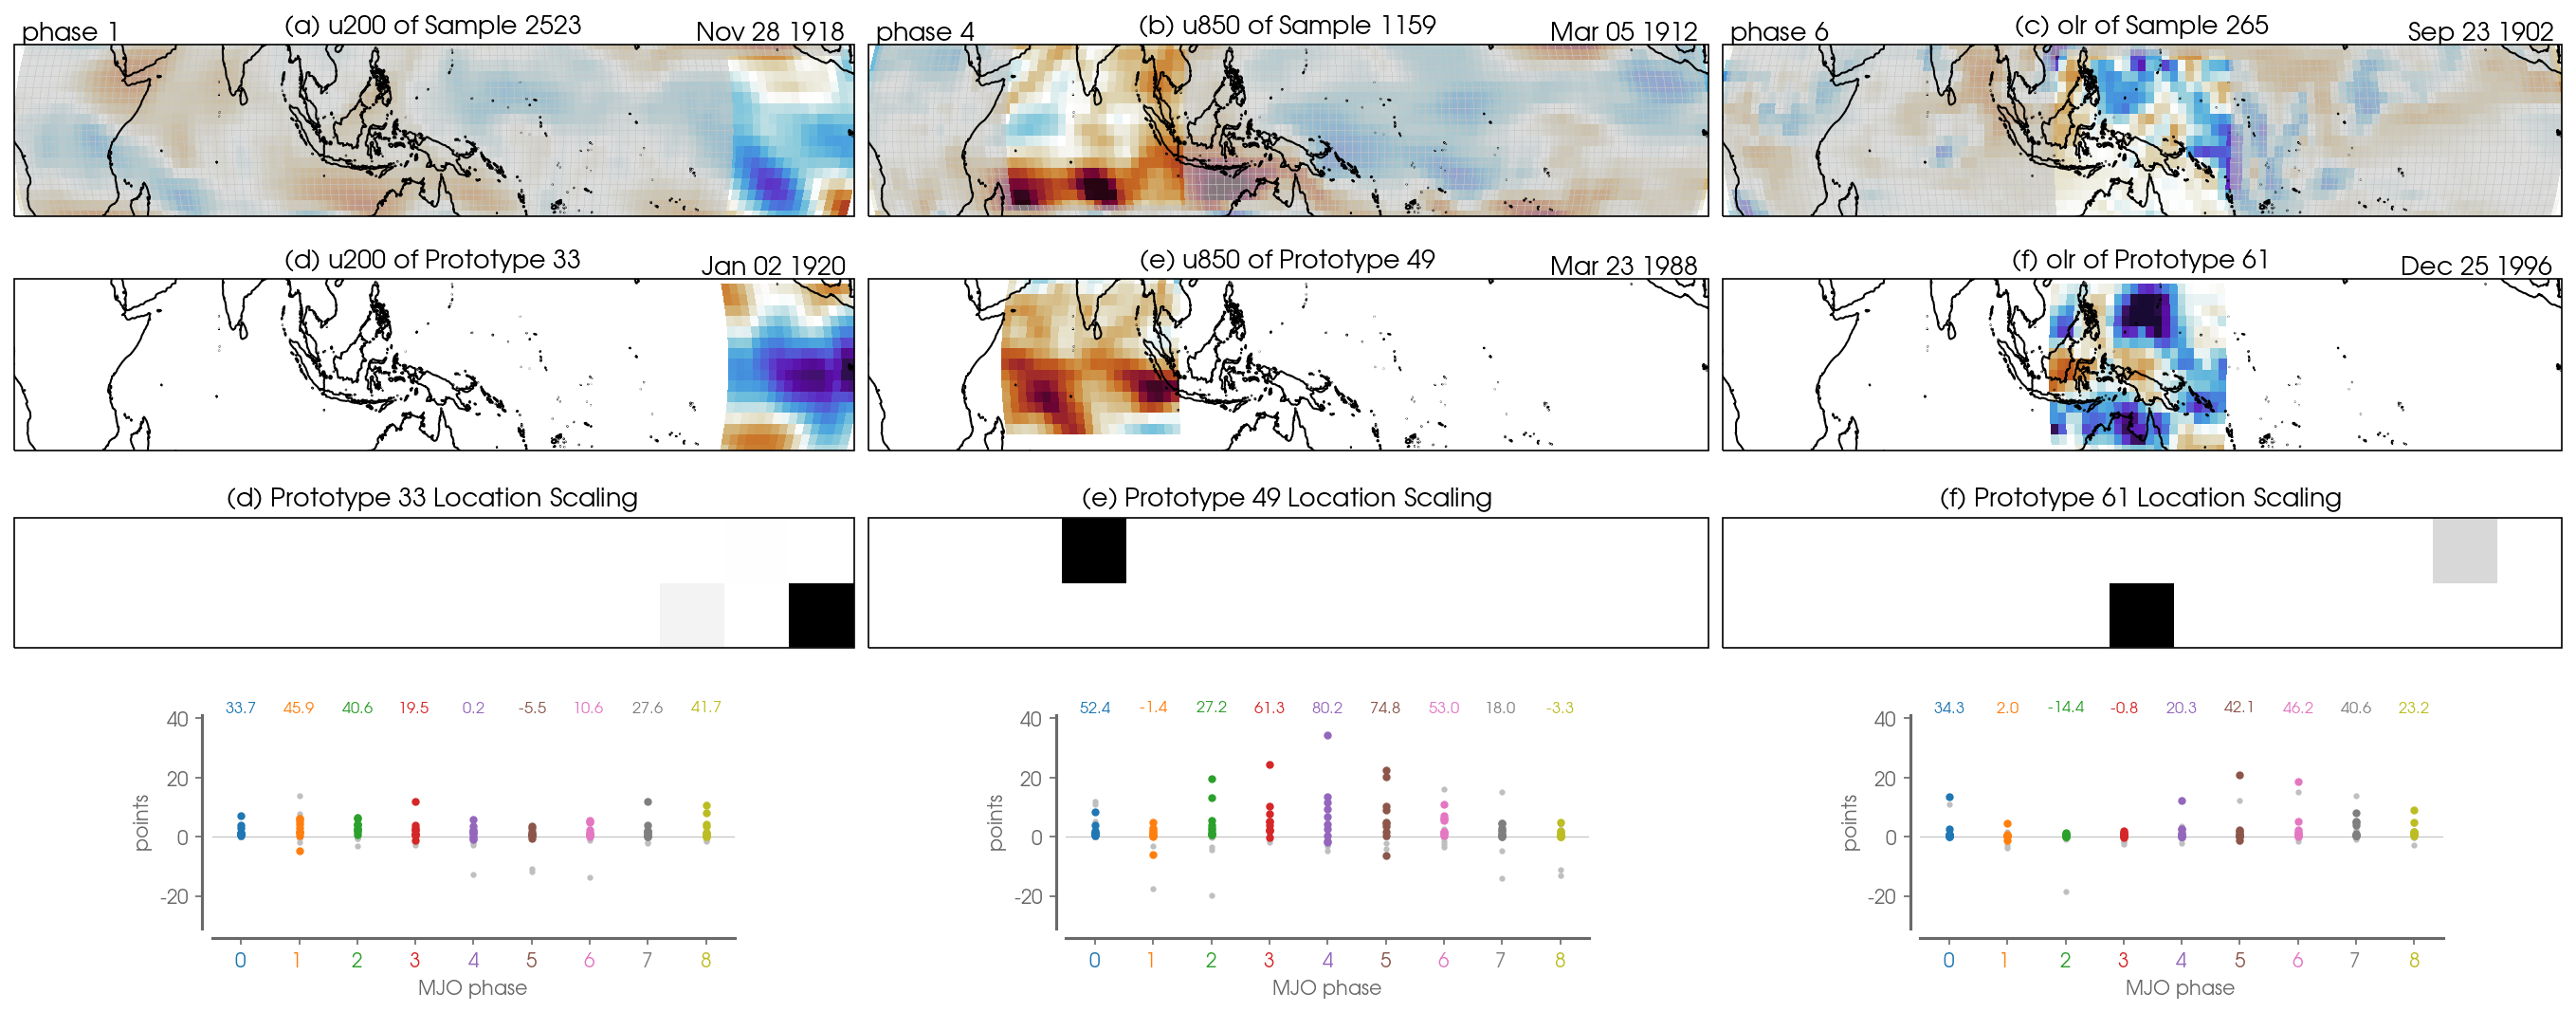

In [29]:
# Prototype examples
if EXP_NAME[:3] == 'mjo':
    mapProj = ct.crs.EqualEarth(central_longitude = np.mean(lon.values))
    imp.reload(plots)
    
    y_predict_class = np.argmax(y_predict,axis=1)
    igrab_samples = np.where(y_predict_class==1)[0]    

    # phase 1 = 6758, var = 1
    # phase 4 = 1159, var = 2
    # phase 7 = 6231, var = 0
    
#     3087, 2523
    SAMPLES = (2523, 1159, 265) #6231
#     SAMPLES = (2200,2200,2200) #1159, 1904
#     SAMPLES = np.random.choice(igrab_samples,size=3)
    
    VAR_INDEX = (1,2,0)
    SORTED_VALUE = (1,1,1)   #(1,2,1) 
    colors = ('tab:purple','tab:orange')
    FS = 13

    #------------------------------
    fig = plt.figure(figsize=(18,7), constrained_layout=True)
    grid_per_col = 7
    spec = gridspec.GridSpec(ncols=3*grid_per_col, nrows=4, figure=fig)

    for isample, sample in enumerate(SAMPLES):

        y_predict_class = int(np.argmax(y_predict[sample]))
        points = max_similarity_score[sample,:]*w[:,y_predict_class]
        all_points = w*np.squeeze(max_similarity_score[sample,:])[:,np.newaxis]
        total_points = np.sum(all_points,axis=0)        
        
        if(np.argmax(y_predict[sample]) != y_true[sample]):
            continue

        #-------------------------------    
        base_col = isample*grid_per_col
        
        var_index = VAR_INDEX[isample]
        if(var_index==0):
            var_name = 'olr'
            letters = ('(c)','(f)','(i)')
        elif(var_index==1):
            var_name = 'u200'
            letters = ('(a)','(d)','(g)')            
        elif(var_index==2):
            var_name = 'u850'
            letters = ('(b)','(e)','(h)')      
        
        #----------------------   

        prototype_points = np.sort(points)[-(SORTED_VALUE[isample])]
        prototype_index = np.where(points == prototype_points)[0][0]
        prototype_class = np.argmax(proto_class_mask[prototype_index])
        if(y_predict_class != prototype_class):
            print_warning = '\n- prototype not associated with predicted class -'
        else:
            print_warning = ''

        #-------------------------------        
        # PLOT THE SAMPLE
        ax_samp = fig.add_subplot(spec[0,base_col:base_col+grid_per_col], projection=mapProj)            
        similarity_map  = similarity_scores[sample,:,:,prototype_index]
        j,k             = np.unravel_index(np.argmax(similarity_map), shape=similarity_map.shape)
        rf              = receptive_field.computeMask(j,k)   
        rf              = np.abs(rf-1.)
        rf[rf==0] = np.nan            
        img = np.squeeze(input_data[0][0][sample,:,:,var_index])
        p = plots.plot_sample_shaded(ax_samp, img, globe=True, lat=lat.values, lon=lon.values, mapProj=mapProj, rf=rf)       
        ax_samp.set_title(letters[0] + ' ' + var_name + ' of Sample ' + str(sample), fontsize=FS)
        ax_samp.text(0.99, 1.0, 
            str(sample_date[sample]),
            fontfamily='monospace', 
            fontsize=FS, 
            va='bottom',
            ha='right',
            transform = ax_samp.transAxes,
           ) 
        ax_samp.text(0.01, 1.0, 
            'phase ' + str(y_predict_class),
            fontfamily='monospace', 
            fontsize=FS, 
            va='bottom',
            ha='left',
            transform = ax_samp.transAxes,
           )            

        #-------------------------------        
        # PLOT THE PROTOTYPES
        ax = fig.add_subplot(spec[1,base_col:base_col+grid_per_col], projection=mapProj)
        rf = receptive_field.computeMask(prototype_indices[prototype_index,0], prototype_indices[prototype_index,1])
        img = np.squeeze(input_train[0][0][prototype_sample[prototype_index],:,:,var_index])*rf
        p = plots.plot_sample(ax, img, globe=True, lat=lat, lon=lon, mapProj=mapProj)
#         ax.set_title(letters[1] + ' ' + var_name + ' of Prototype ' + str(prototype_index) + ' (' + str(np.round(prototype_points,1)) + ' points)', fontsize=FS)
        ax.set_title(letters[1] + ' ' + var_name + ' of Prototype ' + str(prototype_index), fontsize=FS)
        ax.text(0.99, 1.0, 
            str(prototype_date[prototype_index]),
            fontfamily='monospace', 
            fontsize=FS, 
            va='bottom',
            ha='right',
            transform = ax.transAxes,
           ) 

        #-------------------------------        
        # PLOT THE MASKS
        ax = fig.add_subplot(spec[2,base_col:base_col+grid_per_col], projection=mapProj)
        img = local_mask[:,:,prototype_index] 
        img = np.flipud(img)            
        p = plots.plot_mask(ax,img)
        p.set_clim(1.,np.max(img))
        ax.set_title(letters[1] + ' ' + 'Prototype ' + str(prototype_index) + ' Location Scaling', fontsize=FS)

        #-------------------------------        
        # PLOT THE POINTS
        ax = fig.add_subplot(spec[3,base_col+1:base_col+grid_per_col-1])
        plt.axhline(y=0,color='.75',linewidth=.5)    
        for phase in np.arange(0,9):

            i = np.where(proto_class_mask[:,phase]==0)[0]
            plt.plot(np.ones(len(i))*phase,all_points[i,phase],'.',color='.75', markersize=4)

            i = np.where(proto_class_mask[:,phase]==1)[0]
            p = plt.plot(np.ones(len(i))*phase,all_points[i,phase],'.')

            clr = p[0].get_color()
            plt.text(phase,41., 
                     str(np.round(total_points[phase],1)),
                     verticalalignment='bottom',
                     horizontalalignment='center',
                     color=clr,
                     fontsize=8,
        #              weight='bold',
        #              transform=ax.transAxes, 
                    )
        plt.yticks((-20,0,20,40),('-20','0','20','40'))
        plt.ylim(-31,41)          
        plt.xlim(-.5, 8.5)
        plt.xticks(np.arange(0,9),np.arange(0,9))
        plt.xlabel('MJO phase')
        plt.ylabel('points')
        adjust_spines(ax, ['left', 'bottom'])
        ax.spines['top'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.spines['left'].set_color('dimgrey')
        ax.spines['bottom'].set_color('dimgrey')
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)  
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        [t.set_color(i) for (i,t) in
         zip(colors,ax.xaxis.get_ticklabels())]    
        

    # plt.close()   
#     plt.tight_layout()
    plt.savefig((vizualization_dir + EXP_NAME + '_3samples_prototypes.png'), bbox_inches='tight', dpi=dpiFig)
    plt.show()

<ipython-input-30-244889499a51>:159: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig((vizualization_dir + EXP_NAME + '_sample' + str(sample) +'_vars_allprototypes_sorted' + str(sorted_index) + '.png'), bbox_inches='tight', dpi=dpiFig)


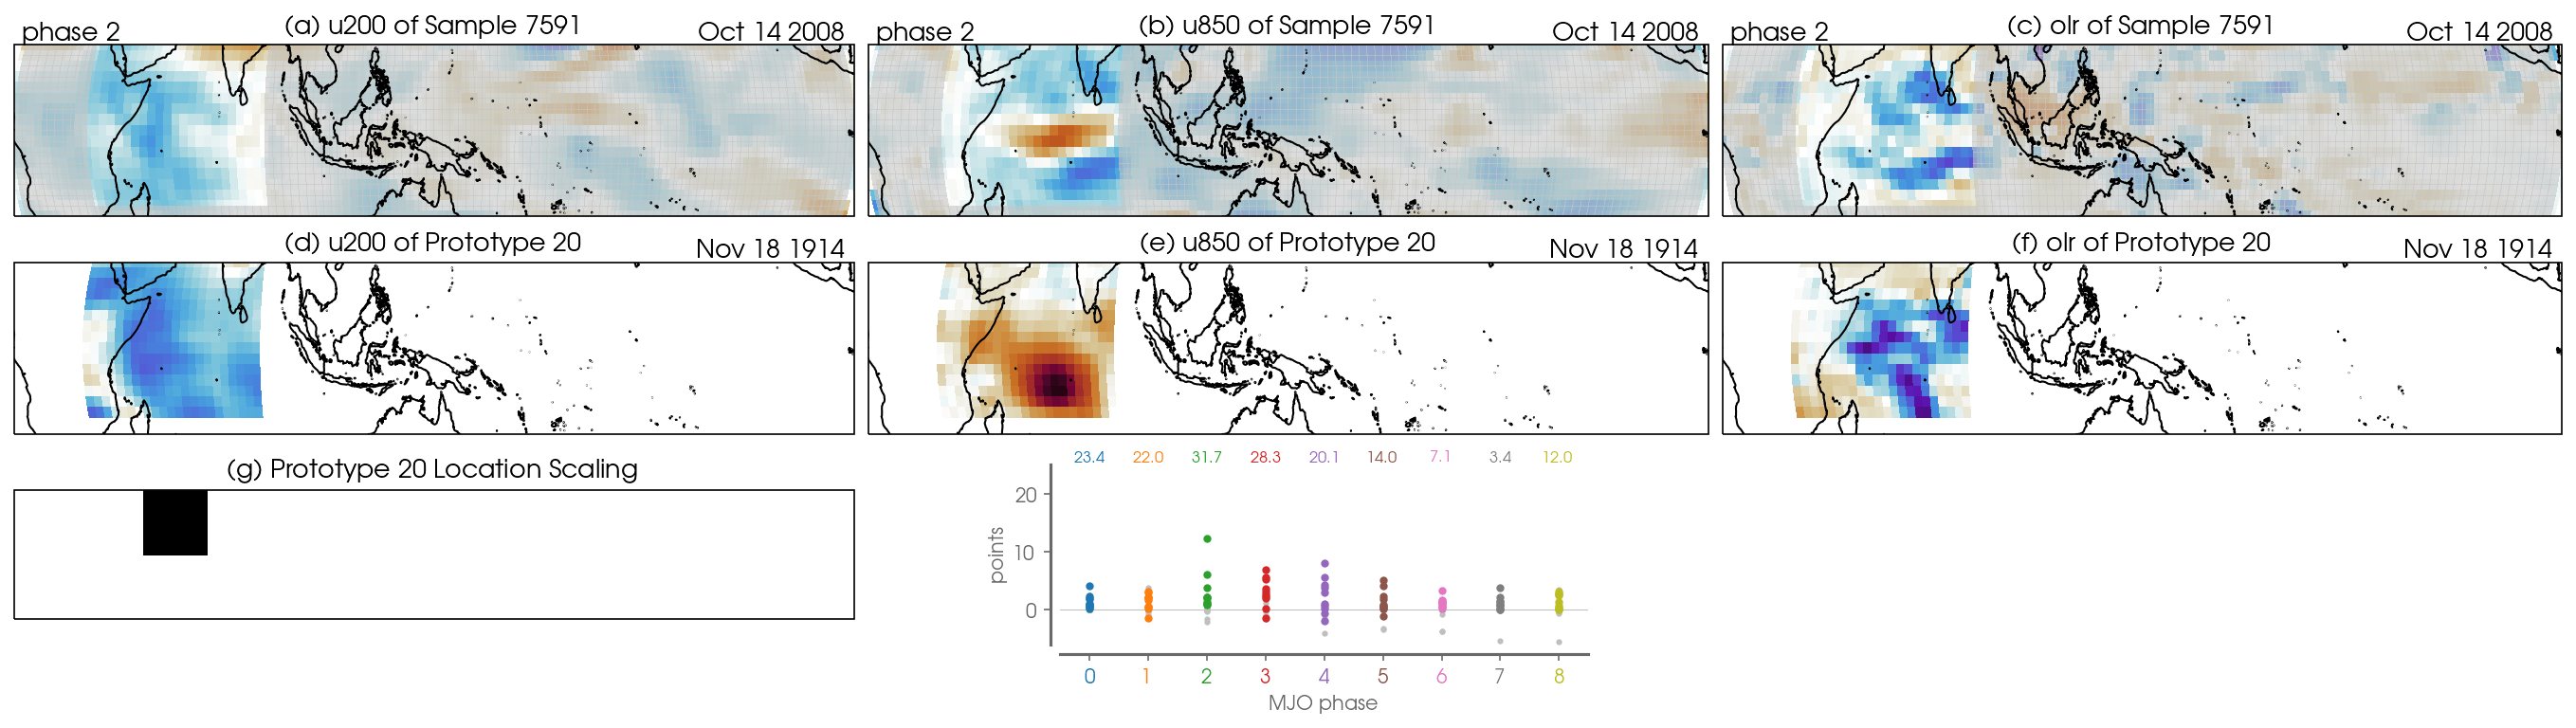

In [30]:
# One sample, all variables - whatever prototype of interest
if EXP_NAME[:3] == 'mjo':
    mapProj = ct.crs.EqualEarth(central_longitude = np.mean(lon.values))
    imp.reload(plots)
    # 4470 - var 0
    # 1159 - var 2
    # 2200 - var 1
    
    y_predict_class = np.argmax(y_predict,axis=1)
    igrab_samples = np.where(y_predict_class==2)[0]        
    
    SAMPLES = (7591, 7591, 7591)
#     SAMPLES = (5955, 5955, 5955) 
#     SAMPLES = (5953, 5953, 5953)
#     SAMPLES = (2210, 2210, 2210)
#     SAMPLES = (850,850,850) #1159, 1904
#     SAMPLES = np.random.choice(igrab_samples,size=3)
    
    VAR_INDEX = (1,2,0)
    colors = ('tab:purple','tab:orange')
    FS = 13

    #------------------------------
    fig = plt.figure(figsize=(18,5), constrained_layout=True)
    grid_per_col = 7
    spec = gridspec.GridSpec(ncols=3*grid_per_col, nrows=3, figure=fig)

    for isample, sample in enumerate(SAMPLES):

        y_predict_class = int(np.argmax(y_predict[sample]))
        points = max_similarity_score[sample,:]*w[:,y_predict_class]
        all_points = w*np.squeeze(max_similarity_score[sample,:])[:,np.newaxis]
        total_points = np.sum(all_points,axis=0)        
        
        if(np.argmax(y_predict[sample]) != y_true[sample]):
            continue

        #-------------------------------    
        base_col = isample*grid_per_col
        
        var_index = VAR_INDEX[isample]
        if(var_index==0):
            var_name = 'olr'
            letters = ('(c)','(f)')
        elif(var_index==1):
            var_name = 'u200'
            letters = ('(a)','(d)')            
        elif(var_index==2):
            var_name = 'u850'
            letters = ('(b)','(e)')            
        
        #----------------------   
        for sorted_index in (1,):
            prototype_points = np.sort(points)[-(sorted_index)]
            prototype_index = np.where(points == prototype_points)[0][0]
            prototype_class = np.argmax(proto_class_mask[prototype_index])
            if(y_predict_class != prototype_class):
                print_warning = '\n- prototype not associated with predicted class -'
            else:
                print_warning = ''

            #-------------------------------        
            # PLOT THE SAMPLE
            ax_samp = fig.add_subplot(spec[0,base_col:base_col+grid_per_col], projection=mapProj)            
            similarity_map  = similarity_scores[sample,:,:,prototype_index]
            j,k             = np.unravel_index(np.argmax(similarity_map), shape=similarity_map.shape)
            rf              = receptive_field.computeMask(j,k)   
            rf              = np.abs(rf-1.)
            rf[rf==0] = np.nan            
            img = np.squeeze(input_data[0][0][sample,:,:,var_index])
            p = plots.plot_sample_shaded(ax_samp, img, globe=True, lat=lat, lon=lon, rf=rf, mapProj=mapProj)
            ax_samp.set_title(letters[0] + ' ' + var_name + ' of Sample ' + str(sample), fontsize=FS)
            ax_samp.text(0.99, 1.0, 
                str(sample_date[sample]),
                fontfamily='monospace', 
                fontsize=FS, 
                va='bottom',
                ha='right',
                transform = ax_samp.transAxes,
               ) 
            ax_samp.text(0.01, 1.0, 
                'phase ' + str(y_predict_class),
                fontfamily='monospace', 
                fontsize=FS, 
                va='bottom',
                ha='left',
                transform = ax_samp.transAxes,
               )            

            #-------------------------------        
            # PLOT THE PROTOTYPES
            ax = fig.add_subplot(spec[1,base_col:base_col+grid_per_col], projection=mapProj)
            rf = receptive_field.computeMask(prototype_indices[prototype_index,0], prototype_indices[prototype_index,1])
            img = np.squeeze(input_train[0][0][prototype_sample[prototype_index],:,:,var_index])*rf
            p = plots.plot_sample(ax, img, globe=True, lat=lat, lon=lon,mapProj=mapProj)
#             ax.set_title(var_name + ' of Prototype ' + str(prototype_index) + ' (' + str(np.round(prototype_points,1)) + ' points)', fontsize=FS)
            ax.set_title(letters[1] + ' ' + var_name + ' of Prototype ' + str(prototype_index), fontsize=FS)
            ax.text(0.99, 1.0, 
                str(prototype_date[prototype_index]),
                fontfamily='monospace', 
                fontsize=FS, 
                va='bottom',
                ha='right',
                transform = ax.transAxes,
               ) 
            
            #-------------------------------        
            # PLOT THE MASKS
            if(var_index==1):
                ax = fig.add_subplot(spec[2,base_col:base_col+grid_per_col], projection=mapProj)
                img = local_mask[:,:,prototype_index] 
                img = np.flipud(img)            
                p = plots.plot_mask(ax,img)
                p.set_clim(1.,np.max(img))
                ax.set_title('(g) Prototype ' + str(prototype_index) + ' Location Scaling', fontsize=FS)

            #-------------------------------        
            # PLOT THE POINTS
            if(var_index==2):            
                ax = fig.add_subplot(spec[2,base_col+1:base_col+grid_per_col-1])
                plt.axhline(y=0,color='.75',linewidth=.5)    
                for phase in np.arange(0,9):

                    i = np.where(proto_class_mask[:,phase]==0)[0]
                    plt.plot(np.ones(len(i))*phase,all_points[i,phase],'.',color='.75', markersize=4)

                    i = np.where(proto_class_mask[:,phase]==1)[0]
                    p = plt.plot(np.ones(len(i))*phase,all_points[i,phase],'.')

                    clr = p[0].get_color()
                    plt.text(phase,25., 
                             str(np.round(total_points[phase],1)),
                             verticalalignment='bottom',
                             horizontalalignment='center',
                             color=clr,
                             fontsize=8,
                #              weight='bold',
                #              transform=ax.transAxes, 
                            )
                plt.ylim(-6,25)  
                plt.yticks((0,10,20),('0','10','20'))
                plt.xlim(-.5, 8.5)
                plt.xticks(np.arange(0,9),np.arange(0,9))
                plt.xlabel('MJO phase')
                plt.ylabel('points')
                adjust_spines(ax, ['left', 'bottom'])
                ax.spines['top'].set_color('none')
                ax.spines['right'].set_color('none')
                ax.spines['left'].set_color('dimgrey')
                ax.spines['bottom'].set_color('dimgrey')
                ax.spines['left'].set_linewidth(1.5)
                ax.spines['bottom'].set_linewidth(1.5) 
                colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
                [t.set_color(i) for (i,t) in
                 zip(colors,ax.xaxis.get_ticklabels())]                    
            
    # plt.close()   
#     plt.tight_layout()
    plt.savefig((vizualization_dir + EXP_NAME + '_sample' + str(sample) +'_vars_allprototypes_sorted' + str(sorted_index) + '.png'), bbox_inches='tight', dpi=dpiFig)
    plt.show()

In [ ]:
# All prototypes for each phase

if EXP_NAME[:3] == 'mjo':
    
    from scipy import stats
    imp.reload(plots)
    mapProj = ct.crs.EqualEarth(central_longitude = np.mean(lon.values))
    FS = 10

    for phase in np.arange(0,9):
        fig, axs = plt.subplots(10,
                            4, 
                            figsize=(21,14),
                            subplot_kw={'projection': mapProj}
                           )        
        isamples = np.where((np.argmax(y_predict,axis=1)==phase) & (np.argmax(y_predict,axis=1)==y_true))[0]
        points = max_similarity_score[isamples,:]*w[:,phase]
        k = np.where(proto_class_mask[:,phase]==0)[0]
        points[:,k] = 0.
        
        winning_prototype = np.argmax(points,axis=1)
        
        points_avg = np.mean(points,axis=0)
        proto_vector = np.where(points_avg != 0)[0]  
        proto_points_vector = points_avg[proto_vector]
        sorted_index = np.argsort(proto_points_vector)


        for ivar, var_index in enumerate((1,2,0)):
            if(var_index==0):
                var_name = 'olr'
            elif(var_index==1):
                var_name = 'u200'
            elif(var_index==2):
                var_name = 'u850'        
                
            for iprototype, prototype_index in enumerate(proto_vector[np.flipud(sorted_index)]):

                #-------------------------------        
                # PLOT THE PROTOTYPES
                ax = axs[iprototype,ivar]
                rf = receptive_field.computeMask(prototype_indices[prototype_index,0], prototype_indices[prototype_index,1])
                img = np.squeeze(input_train[0][0][prototype_sample[prototype_index],:,:,var_index])*rf
                p = plots.plot_sample(ax,
                                      img,
                                      globe=True,
                                      lat=lat,
                                      lon=lon,
                                      mapProj=mapProj,
                                     )
                p.set_clim(-7,7)
                ax.set_title(var_name + ' of Prototype ' + str(prototype_index), fontsize=FS*1.25)
                ax.text(0.01, 1.0, 
                    'phase ' + str(phase),
                    fontfamily='monospace', 
                    fontsize=FS, 
                    va='bottom',
                    ha='left',
                    transform = ax.transAxes,
                   )
                ax.text(0.99, 1.0, 
                    str(prototype_date[prototype_index]),
                    fontfamily='monospace', 
                    fontsize=FS, 
                    va='bottom',
                    ha='right',
                    transform = ax.transAxes,
                   )            
                #-------------------------------        
                # PLOT THE MASKS
                if var_index==0:
                    iwin = np.where(winning_prototype==prototype_index)[0]
                    win_frac = int(np.round(len(iwin)/len(winning_prototype)*100))
                    
                    ax = axs[iprototype,3]
                    img = local_mask[:,:,prototype_index] 
                    img = np.flipud(img)
                    p = plots.plot_mask(ax,img)
                    p.set_clim(1.,np.max(img[:]))
                    ax.set_title('Prototype ' + str(prototype_index) + ' Location Scaling', fontsize=FS*1.25)
                    
                    ax.text(0.00, 1.0, 
                        str(np.round(points_avg[prototype_index],1)) + ' pts.',
                        fontfamily='monospace', 
                        fontsize=FS, 
                        va='bottom',
                        ha='left',
                        transform = ax.transAxes,
                           )
                    ax.text(1.0, 1.0, 
                        str(win_frac) + '\% win',
                        fontfamily='monospace', 
                        fontsize=FS, 
                        va='bottom',
                        ha='right',
                        transform = ax.transAxes,
                           )            

    
        plt.savefig((vizualization_dir + EXP_NAME + '_allPrototypes_phase' + str(phase) + '.png'), bbox_inches='tight', dpi=dpiFig)
#         plt.show()   
#         raise ValueError('here')
        plt.close()